# Description

Look for any data relational patterns and things that would be helpful in understanding the data and customer behavior.

# Prepare data 


In [1]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy.stats import chi2_contingency
import geocoder
import statistics

from sklearn.preprocessing import MinMaxScaler, StandardScaler


In [2]:
%reload_kedro

/Users/xszpo/miniconda3/envs/viabill/lib/python3.8/site-packages/kedro/framework/project/__init__.py:133: UserWarning: Found duplicate pipeline entries. The following will be overwritten: __default__
  warn(


In [3]:
df_cust = catalog.load("customers")
d_sex = {1: 'male', 2:'female', 0: 'other'}
df_cust.sex = df_cust.sex.apply(lambda x: d_sex[x])

df_cust['residentialAddress_clean'] = df_cust.residentialAddress.apply(lambda x: re.sub(r'[0-9]+', '', x))
df_cust['postalAddress_clean']  = df_cust.postalAddress.apply(lambda x: re.sub(r'[0-9]+', '', x) if x==x else '')
df_cust['same_address'] = (df_cust.residentialAddress==df_cust.postalAddress).astype(int)


## Perform some basic future engineering

In [4]:
df_trans = catalog.load("transactions")
df_trans['late'] = df_trans.filter(regex='payment').apply(lambda x: x==1).any(axis=1).astype(int)
df_trans['default'] = df_trans.filter(regex='payment').apply(lambda x: x==2).any(axis=1).astype(int)

df_trans["defualted_payment"] = df_trans.replace({
    'paymentStatus1': {1: 0, 2: 1},
    'paymentStatus2': {1: 0, 2: 2},
    'paymentStatus3': {1: 0, 2: 3},
    'paymentStatus4': {1: 0, 2: 4},
}).filter(regex='payment').replace({0: np.nan}).min(axis=1).fillna(0)

df_trans["late_payment_first"] = df_trans.replace({
    'paymentStatus1': {1: 1, 2: 0},
    'paymentStatus2': {1: 2, 2: 0},
    'paymentStatus3': {1: 3, 2: 0},
    'paymentStatus4': {1: 4, 2: 0},
}).filter(regex='payment').replace({0: np.nan}).min(axis=1).fillna(0)

In [5]:
df_trans = df_trans.assign(
    money_lost = lambda x: x.apply(
        lambda y:y['price'] * (5-y['defualted_payment'])/4 if y['defualted_payment']>0 else 0, axis=1
    )
)

In [6]:
print(f"""
Numer of rows in 'customers' table - {df_cust.shape[0]/1000:.0f} K.
Numer of columns in 'customers' table - {df_cust.shape[1]}.

Numer of rows in 'transactions' table - {df_trans.shape[0]/1000000:.0f} M.
Numer of columns in 'transactions' table - {df_trans.shape[1]}.

Numer of uniqe customers in 'customers' table - {len(df_cust.customerID.unique())/1000:.0f} K.
Numer of uniqe customers in 'transactions' table - {len(df_trans.customerID.unique())/1000:.0f} K.
""")


Numer of rows in 'customers' table - 500 K.
Numer of columns in 'customers' table - 9.

Numer of rows in 'transactions' table - 2 M.
Numer of columns in 'transactions' table - 13.

Numer of uniqe customers in 'customers' table - 500 K.
Numer of uniqe customers in 'transactions' table - 491 K.



## Perform some basic quality check

Check if rows in data in Customer and Transactions tables are not duplicated

In [7]:
if df_cust.customerID.nunique() == df_cust.shape[0]:
    print("Data in Customer table are NOT duplicated.")
else:
    print("Data in Customer table ARE duplicated.")

Data in Customer table are NOT duplicated.


In [8]:
if df_trans.transactionID.nunique() == df_trans.shape[0]:
    print("Data in Transactions table are NOT duplicated.")
else:
    print("Data in Transactions table ARE duplicated.")

Data in Transactions table are NOT duplicated.


# Analyze the data

## Customers table

In [9]:
df_cust.head()

,customerID,sex,age,residentialAddress,postalAddress,income,residentialAddress_clean,postalAddress_clean,same_address
0,1,male,25,28 Irvine Place,28 Irvine Place,NaN,Irvine Place,Irvine Place,1
1,2,male,19,72 Bertha Street,72 Bertha Street,43200.0,Bertha Street,Bertha Street,1
2,3,female,22,63 Ladberry Street,63 Ladberry Street,70200.0,Ladberry Street,Ladberry Street,1
3,4,other,24,98 Linneman Close,98 Linneman Close,93900.0,Linneman Close,Linneman Close,1
4,5,male,53,56 Salonica Road,56 Salonica Road,77000.0,Salonica Road,Salonica Road,1


In [10]:
df_cust.describe().T.style.format({'mean': '{:.2f}'})

,count,mean,std,min,25%,50%,75%,max
customerID,500000.000000,250000.50,144337.711635,1.000000,125000.750000,250000.500000,375000.250000,500000.000000
age,500000.000000,44.63,16.178283,5.000000,27.000000,50.000000,58.000000,90.000000
income,490025.000000,50000.04,28899.119696,0.000000,25000.000000,50000.000000,75000.000000,100000.000000
same_address,500000.000000,0.93,0.254364,0.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
print("Nulls percentage:")
(df_cust.replace('',np.nan).isna().sum()/ df_cust.shape[0]).map(lambda x:'{:.2f}%'.format(x*100))

Nulls percentage:


customerID                  0.00%
sex                         0.00%
age                         0.00%
residentialAddress          0.00%
postalAddress               2.02%
income                      1.99%
residentialAddress_clean    0.00%
postalAddress_clean         2.02%
same_address                0.00%
dtype: object

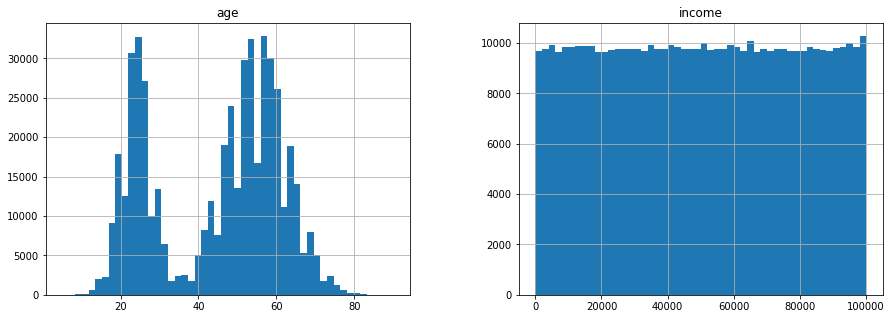

In [12]:
%matplotlib inline
df_cust[['age','income']].hist(bins=50, figsize=(15,5)) 
plt.show()

* there are two customer segments, given age: ~25 years, ~55 years, 


### sex vs age

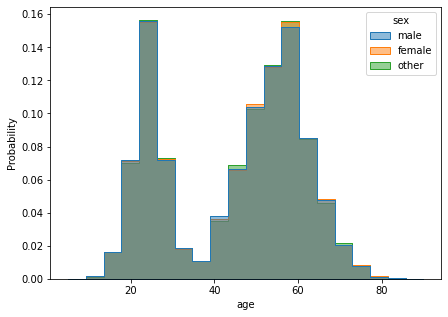

In [13]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(7,5))
sns.histplot(df_cust, x="age", hue="sex", ax=ax, alpha=0.5, bins=20, element="step", stat="probability", common_norm=False)
plt.show()

In [14]:
_tmp = pd.crosstab(df_cust.sex, pd.cut(df_cust.age, 7), rownames=['sex'], colnames=['age'])
_tmp.style.background_gradient(cmap ='Blues',axis=1)


age,"(4.915, 17.143]","(17.143, 29.286]","(29.286, 41.429]","(41.429, 53.571]","(53.571, 65.714]","(65.714, 77.857]","(77.857, 90.0]"
sex,,,,,,,
female,1778,28840,5806,25381,32238,6095,190
male,6574,108134,22081,94778,119441,22950,587
other,438,7246,1408,6409,8053,1532,41


In [15]:
# Tests whether two categorical variables are related or independent.
# assumptions:
# * Observations used in the calculation of the contingency table are independent.
# 25 or more examples in each cell of the contingency table.
#H0: the two samples are independent.
#H1: there is a dependency between the samples.

table = [_tmp.values]
stat, p, dof, expected = chi2_contingency(table)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

stat=12.594, p=0.399
Probably independent


Sex and age are probably independent

### sex vs income

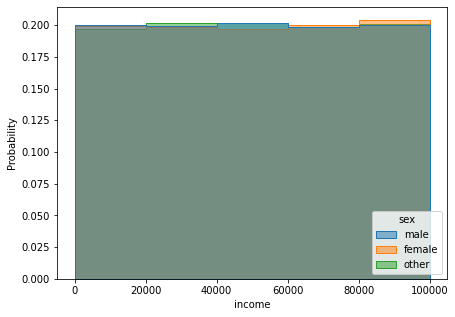

In [16]:
%matplotlib inline

def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)
    
fig, ax = plt.subplots(figsize=(7,5))
g = sns.histplot(df_cust, x="income", hue="sex", ax=ax, alpha=0.5, bins=5, 
             element="step", stat="probability", common_norm=False)

move_legend(ax, 4)


In [17]:
_tmp = pd.crosstab(df_cust.sex, pd.cut(df_cust.income, 5), rownames=['sex'], colnames=['income'])
_tmp.style.background_gradient(cmap ='Blues',axis=1)

income,"(-100.0, 20000.0]","(20000.0, 40000.0]","(40000.0, 60000.0]","(60000.0, 80000.0]","(80000.0, 100000.0]"
sex,,,,,
female,19683,19591,19400,19731,19976
male,73967,73099,73852,73061,73017
other,4879,4978,4964,4900,4927


In [18]:
#Chi-Squared Test
table = [_tmp.values]
stat, p, dof, expected = chi2_contingency(table)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

stat=16.843, p=0.032
Probably dependent


There may be dependency between sex and income, 

### age vs income

In [19]:
from pandas.plotting import scatter_matrix

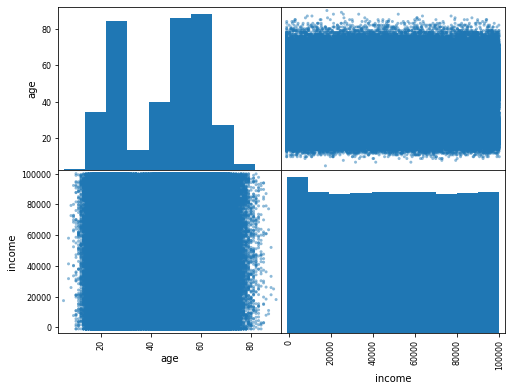

In [20]:
%matplotlib inline
attributes = ['age','income']
scatter_matrix(df_cust[attributes].fillna(-999), figsize=(8, 6))
plt.show()

In [21]:
_tmp = pd.crosstab(pd.cut(df_cust.fillna(-999).income, 7), pd.cut(df_cust.age, 7), rownames=['income'], colnames=['age'])
_tmp.style.background_gradient(cmap ='Blues',axis=1)

age,"(4.915, 17.143]","(17.143, 29.286]","(29.286, 41.429]","(41.429, 53.571]","(53.571, 65.714]","(65.714, 77.857]","(77.857, 90.0]"
income,,,,,,,
"(-1099.999, 13429.429]",1324,21957,4434,19351,24249,4669,120
"(13429.429, 27857.857]",1244,20311,4188,17871,22293,4348,113
"(27857.857, 42286.286]",1238,20360,4114,17930,22551,4312,110
"(42286.286, 56714.714]",1203,20784,4091,17650,22829,4332,125
"(56714.714, 71143.143]",1258,20409,4162,17753,22666,4231,121
"(71143.143, 85571.571]",1273,19978,4100,17859,22549,4275,121
"(85571.571, 100000.0]",1250,20421,4206,18154,22595,4410,108


In [22]:
#Chi-Squared Test
table = [_tmp.values]
stat, p, dof, expected = chi2_contingency(table)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

stat=34.090, p=0.560
Probably independent


Age and income are probably independent

# Transactions table

In [23]:
df_trans.head()

,transactionID,shopID,customerID,price,paymentStatus1,paymentStatus2,paymentStatus3,paymentStatus4,late,default,defualted_payment,late_payment_first,money_lost
0,1,114,2869.0,140,0,0,0,0,0,0,0.0,0.0,0.0
1,2,855,124077.0,70,0,0,0,0,0,0,0.0,0.0,0.0
2,3,752,86184.0,85,0,0,0,0,0,0,0.0,0.0,0.0
3,4,246,248861.0,43,1,0,0,0,1,0,0.0,1.0,0.0
4,5,973,162112.0,127,0,0,0,0,0,0,0.0,0.0,0.0


General data statistics

In [24]:
df_trans.describe().T.style.format({'mean': '{:.2f}'})

,count,mean,std,min,25%,50%,75%,max
transactionID,2000000.000000,1000000.50,577350.413527,1.000000,500000.750000,1000000.500000,1500000.250000,2000000.000000
shopID,2000000.000000,549.25,259.847443,100.000000,324.000000,549.000000,774.000000,999.000000
customerID,1979983.000000,250095.15,144288.944851,1.000000,125139.000000,250096.000000,375093.000000,500000.000000
price,2000000.000000,101.53,57.175753,3.000000,52.000000,102.000000,151.000000,200.000000
paymentStatus1,2000000.000000,0.12,0.360735,0.000000,0.000000,0.000000,0.000000,2.000000
paymentStatus2,2000000.000000,0.15,0.427886,0.000000,0.000000,0.000000,0.000000,2.000000
paymentStatus3,2000000.000000,0.19,0.505364,0.000000,0.000000,0.000000,0.000000,2.000000
paymentStatus4,2000000.000000,0.27,0.616858,0.000000,0.000000,0.000000,0.000000,2.000000
late,2000000.000000,0.29,0.455622,0.000000,0.000000,0.000000,1.000000,1.000000
default,2000000.000000,0.09,0.289078,0.000000,0.000000,0.000000,0.000000,1.000000


25% of customers are late with second payment    
max price is `$200`, average price is `$102`    
average lost on transaction is `$5`
 

In [25]:
print("Nulls percentage:")
(df_trans.replace('',np.nan).isna().sum()/ df_trans.shape[0]).map(lambda x:'{:.2f}%'.format(x*100))

Nulls percentage:


transactionID         0.00%
shopID                0.00%
customerID            1.00%
price                 0.00%
paymentStatus1        0.00%
paymentStatus2        0.00%
paymentStatus3        0.00%
paymentStatus4        0.00%
late                  0.00%
default               0.00%
defualted_payment     0.00%
late_payment_first    0.00%
money_lost            0.00%
dtype: object

There are some transacions withou customer ID.   
Lets have a look at it

In [26]:
_tmp = pd.concat([
    df_trans.describe().T[['mean']].reset_index(drop=False),
    df_trans.query("customerID != customerID").describe().T[['mean']].reset_index(drop=True)
], axis=1)
_tmp.columns=['column','all-mean','noCustId-mean']
_tmp.style.format({'all-mean': '{:.2f}','noCustId-mean': '{:.2f}'})

,column,all-mean,noCustId-mean
0,transactionID,1000000.50,994726.03
1,shopID,549.25,551.78
2,customerID,250095.15,nan
3,price,101.53,102.37
4,paymentStatus1,0.12,0.12
5,paymentStatus2,0.15,0.15
6,paymentStatus3,0.19,0.18
7,paymentStatus4,0.27,0.27
8,late,0.29,0.29
9,default,0.09,0.09


there is almost no difference in data distribution, it makes no harm 

## Shops

In [27]:
df_trans.head()

,transactionID,shopID,customerID,price,paymentStatus1,paymentStatus2,paymentStatus3,paymentStatus4,late,default,defualted_payment,late_payment_first,money_lost
0,1,114,2869.0,140,0,0,0,0,0,0,0.0,0.0,0.0
1,2,855,124077.0,70,0,0,0,0,0,0,0.0,0.0,0.0
2,3,752,86184.0,85,0,0,0,0,0,0,0.0,0.0,0.0
3,4,246,248861.0,43,1,0,0,0,1,0,0.0,1.0,0.0
4,5,973,162112.0,127,0,0,0,0,0,0,0.0,0.0,0.0


In [28]:
pd.DataFrame(df_trans.shopID.value_counts().values, columns=['Number of transactions in Shops']).describe()

,Number of transactions in Shops
count,900.000000
mean,2222.222222
std,46.310741
min,2087.000000
25%,2192.000000
50%,2223.000000
75%,2253.000000
max,2379.000000


array([[<AxesSubplot:title={'center':'Number of transactions in Shops'}>]],
      dtype=object)

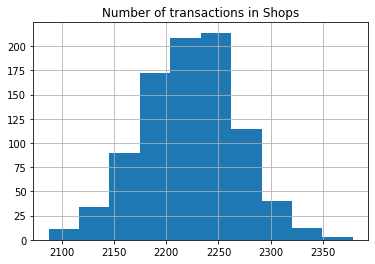

In [29]:
pd.DataFrame(df_trans.shopID.value_counts().values, columns=['Number of transactions in Shops']).hist()

<AxesSubplot:xlabel='shopID', ylabel='transaction_count'>

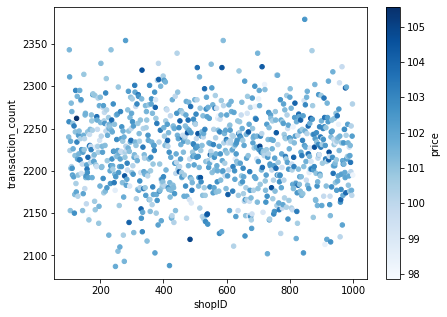

In [30]:
fig, ax = plt.subplots(figsize=(7,5))

df_trans.groupby('shopID').agg(
    transaction_count=('transactionID', 'count'),
    price=('price', 'mean')
).reset_index().plot(x='shopID',y='transaction_count', c= 'price', kind='scatter',colormap="Blues", ax=ax)

Number of transactions and average price are almost the same for all shops.

<AxesSubplot:xlabel='shopID', ylabel='transaction_count'>

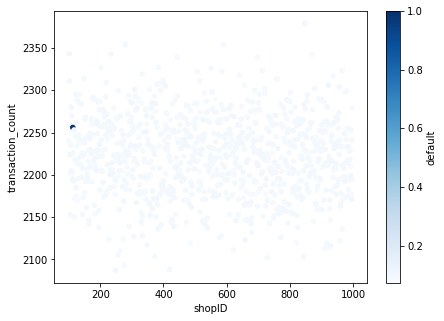

In [31]:
fig, ax = plt.subplots(figsize=(7,5))

df_trans.groupby('shopID').agg(
    transaction_count=('transactionID', 'count'),
    default=('default', 'mean')
).reset_index().plot(x='shopID',y='transaction_count', c= 'default', kind='scatter',colormap="Blues", ax=ax)

There is one shop that seems to be fraud.

In [32]:
df_trans.groupby('shopID').agg(
    transaction_count=('transactionID', 'count'),
    default=('default', 'mean')
).sort_values(by='default').tail(5)

,transaction_count,default
shopID,,
190,2260,0.107080
623,2269,0.107096
658,2123,0.107866
450,2199,0.108686
113,2256,1.000000


Instalments from shop "113" are never paid back- it either corrupted data or fraud.    
I will indicate this shop initially as fraud and will be omitting in further analysis.    


In [33]:
df_trans.loc[df_trans.shopID == 113]

,transactionID,shopID,customerID,price,paymentStatus1,paymentStatus2,paymentStatus3,paymentStatus4,late,default,defualted_payment,late_payment_first,money_lost
1701,1702,113,9169.0,9,2,2,2,2,0,1,1.0,1.0,9.0
2530,2531,113,325418.0,122,2,2,2,2,0,1,1.0,1.0,122.0
3567,3568,113,457004.0,123,2,2,2,2,0,1,1.0,1.0,123.0
4577,4578,113,93714.0,70,2,2,2,2,0,1,1.0,1.0,70.0
4723,4724,113,177400.0,96,2,2,2,2,0,1,1.0,1.0,96.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995352,1995353,113,337672.0,80,2,2,2,2,0,1,1.0,1.0,80.0
1996060,1996061,113,120027.0,180,2,2,2,2,0,1,1.0,1.0,180.0
1998490,1998491,113,287125.0,34,2,2,2,2,0,1,1.0,1.0,34.0
1998904,1998905,113,419778.0,180,2,2,2,2,0,1,1.0,1.0,180.0


In [34]:
df_trans['fraud'] = 0
df_trans.loc[df_trans.shopID == 113,'fraud'] = 1

### shops without fraudulent one

<AxesSubplot:xlabel='shopID', ylabel='transaction_count'>

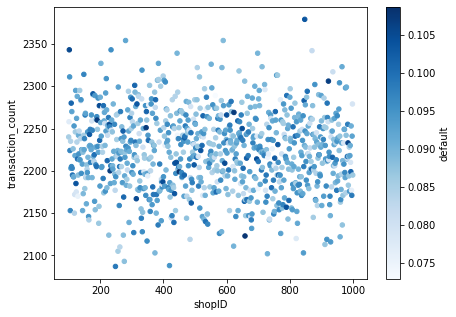

In [35]:
fig, ax = plt.subplots(figsize=(7,5))

df_trans.query("fraud==0").groupby('shopID').agg(
    transaction_count=('transactionID', 'count'),
    default=('default', 'mean')
).reset_index().plot(x='shopID',y='transaction_count', c= 'default', kind='scatter',colormap="Blues", ax=ax)


In [36]:
df_trans.query("fraud==0").groupby('shopID').agg(
    transaction_count=('transactionID', 'count'),
    defualted_payment=('defualted_payment', 'mean')
).reset_index().sort_values('defualted_payment')

,shopID,transaction_count,defualted_payment
463,564,2289,0.211883
252,353,2278,0.216418
629,730,2216,0.216606
598,699,2179,0.217531
1,101,2258,0.219221
...,...,...,...
883,984,2233,0.330945
821,922,2306,0.331310
562,663,2215,0.331828
349,450,2199,0.332879


<AxesSubplot:xlabel='shopID', ylabel='transaction_count'>

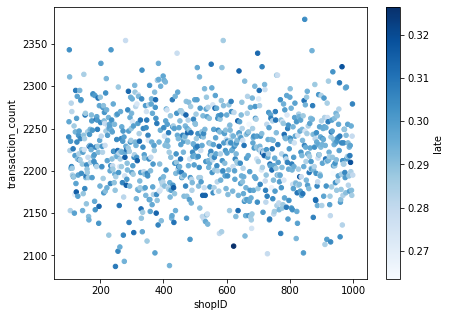

In [37]:
fig, ax = plt.subplots(figsize=(7,5))

df_trans.query("fraud==0").groupby('shopID').agg(
    transaction_count=('transactionID', 'count'),
    late=('late', 'mean')
).reset_index().plot(x='shopID',y='transaction_count', c= 'late', kind='scatter',colormap="Blues", ax=ax)

# Customers transactions

In [38]:
df_trans

,transactionID,shopID,customerID,price,paymentStatus1,paymentStatus2,paymentStatus3,paymentStatus4,late,default,defualted_payment,late_payment_first,money_lost,fraud
0,1,114,2869.0,140,0,0,0,0,0,0,0.0,0.0,0.00,0
1,2,855,124077.0,70,0,0,0,0,0,0,0.0,0.0,0.00,0
2,3,752,86184.0,85,0,0,0,0,0,0,0.0,0.0,0.00,0
3,4,246,248861.0,43,1,0,0,0,1,0,0.0,1.0,0.00,0
4,5,973,162112.0,127,0,0,0,0,0,0,0.0,0.0,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999995,1999996,758,333312.0,12,0,0,1,1,1,0,0.0,3.0,0.00,0
1999996,1999997,932,31802.0,145,0,2,2,2,0,1,2.0,2.0,108.75,0
1999997,1999998,932,449391.0,19,0,0,0,0,0,0,0.0,0.0,0.00,0
1999998,1999999,878,433902.0,198,0,1,0,0,1,0,0.0,2.0,0.00,0


In [39]:
_tmp = df_trans.groupby("customerID").agg(
    transaction_count=('transactionID', 'count'),
    price_avg=('price', 'mean'),
    money_lost_avg=('money_lost', 'mean'),
    late_avg=('late', 'mean'),
    default_avg=('default', 'mean'),
).reset_index()

In [40]:
_tmp.describe()

,customerID,transaction_count,price_avg,money_lost_avg,late_avg,default_avg
count,490533.000000,490533.000000,490533.000000,490533.000000,490533.000000,490533.000000
mean,249973.179978,4.036391,101.538044,4.685877,0.294494,0.091845
std,144332.983398,1.927140,32.957038,12.189746,0.294082,0.185714
min,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000
25%,124989.000000,3.000000,80.600000,0.000000,0.000000,0.000000
50%,249977.000000,4.000000,101.500000,0.000000,0.250000,0.000000
75%,374973.000000,5.000000,122.500000,2.000000,0.500000,0.142857
max,500000.000000,16.000000,200.000000,200.000000,1.000000,1.000000


average lost on client is ~`$19` (4 * $4,7).  



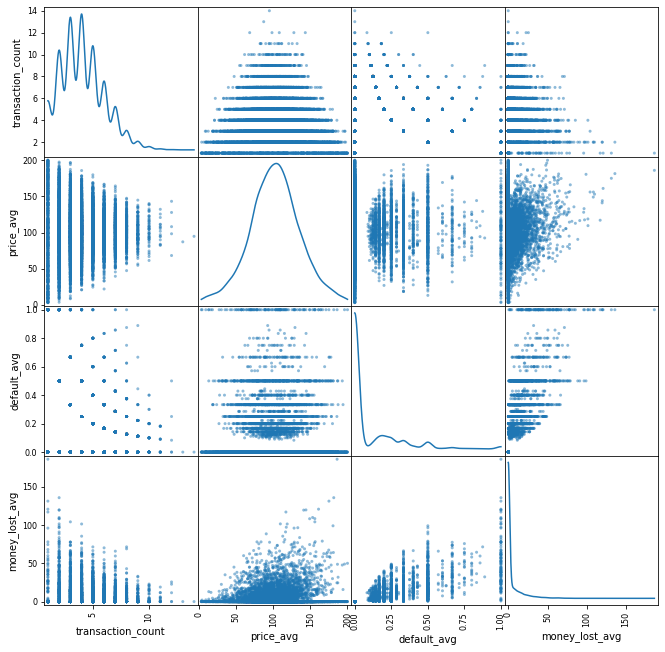

In [41]:
%matplotlib inline
attributes = ['transaction_count','price_avg','default_avg','money_lost_avg']
scatter_matrix(_tmp[attributes].sample(10000, random_state=1), figsize=(11, 11), diagonal='kde')
plt.show()

<AxesSubplot:xlabel='transaction_count'>

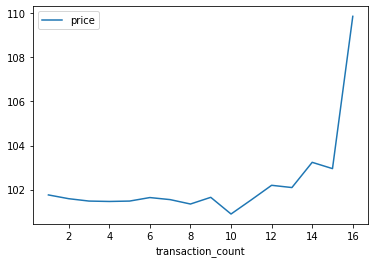

In [42]:
_tmp.groupby('transaction_count').agg(price=('price_avg', 'mean')).plot()

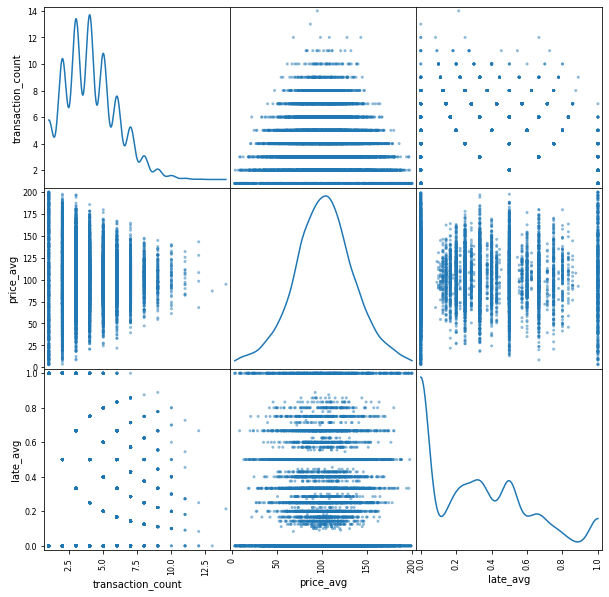

In [43]:
%matplotlib inline
attributes = ['transaction_count','price_avg','late_avg']
scatter_matrix(_tmp[attributes].sample(10000, random_state=1), figsize=(10, 10), diagonal='kde')
plt.show()

# Shops transactions

In [44]:
_tmp = df_trans.query("fraud==0").groupby('shopID').agg(
    transaction_count=('transactionID', 'count'),
    price_avg=('price', 'mean'),
    late_avg=('late', 'mean'),
    default_avg=('default', 'mean'),
    defualted_payment_avg=('defualted_payment', 'mean'),
    money_lost_avg=('money_lost', 'sum')
).reset_index()
_tmp.describe()

,shopID,transaction_count,price_avg,late_avg,default_avg,defualted_payment_avg,money_lost_avg
count,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000
mean,549.985539,2222.184650,101.529381,0.294394,0.091015,0.274566,10195.674360
std,259.687968,46.322792,1.228684,0.009453,0.006199,0.020652,897.595488
min,100.000000,2087.000000,97.857409,0.263541,0.072958,0.211883,7833.000000
25%,325.500000,2192.000000,100.716603,0.287597,0.087015,0.260724,9594.625000
50%,550.000000,2223.000000,101.510975,0.294742,0.091150,0.274833,10174.250000
75%,774.500000,2253.000000,102.306196,0.301154,0.095195,0.288432,10828.625000
max,999.000000,2379.000000,105.557029,0.326386,0.108686,0.339823,12838.500000


Numerical data distribution

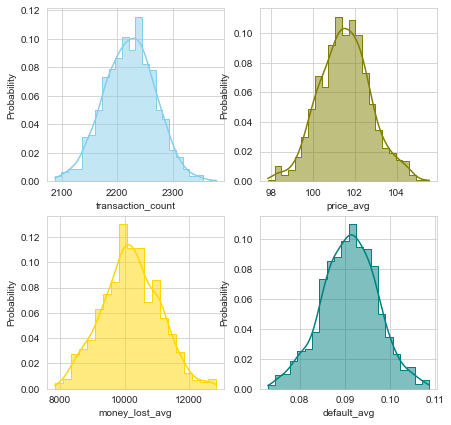

In [45]:
%matplotlib inline

sns.set_style("whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(7, 7))

sns.histplot(data=_tmp, x="transaction_count", kde=True, color="skyblue", ax=axs[0, 0], element="step", stat="probability")
sns.histplot(data=_tmp.astype(np.float32), x="price_avg", kde=True, color="olive", ax=axs[0, 1], element="step", stat="probability")
sns.histplot(data=_tmp, x="default_avg", kde=True, color="teal", ax=axs[1, 1], element="step", stat="probability")
sns.histplot(data=_tmp, x="money_lost_avg", kde=True, color="gold", ax=axs[1, 0], element="step", stat="probability")

plt.show()

In [46]:
_tmp.describe()

,shopID,transaction_count,price_avg,late_avg,default_avg,defualted_payment_avg,money_lost_avg
count,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000
mean,549.985539,2222.184650,101.529381,0.294394,0.091015,0.274566,10195.674360
std,259.687968,46.322792,1.228684,0.009453,0.006199,0.020652,897.595488
min,100.000000,2087.000000,97.857409,0.263541,0.072958,0.211883,7833.000000
25%,325.500000,2192.000000,100.716603,0.287597,0.087015,0.260724,9594.625000
50%,550.000000,2223.000000,101.510975,0.294742,0.091150,0.274833,10174.250000
75%,774.500000,2253.000000,102.306196,0.301154,0.095195,0.288432,10828.625000
max,999.000000,2379.000000,105.557029,0.326386,0.108686,0.339823,12838.500000


### Try to create a segments of the similar shops

There are many shops and it's hard to look and analyse each one.    
Check if it is possible to create segments of similar shops.   

In [47]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
X=scaler.fit_transform(_tmp.iloc[:,1:])

In [48]:
from sklearn.manifold import TSNE
data_sample_pca_embedded = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300).fit_transform(X)


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 899 samples in 0.001s...
[t-SNE] Computed neighbors for 899 samples in 0.040s...
[t-SNE] Computed conditional probabilities for sample 899 / 899
[t-SNE] Mean sigma: 0.125951
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.830185
[t-SNE] KL divergence after 300 iterations: 1.323774


<AxesSubplot:xlabel='x', ylabel='y'>

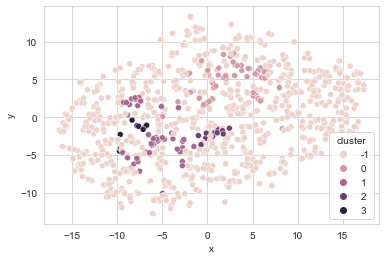

In [49]:

from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA, IncrementalPCA

clustering = DBSCAN(eps=0.13, min_samples=10).fit(X)
set(clustering.labels_)

pca_clusters = pd.DataFrame(data_sample_pca_embedded, columns=['x','y']).assign(
    cluster=clustering.labels_, 
    dr=_tmp.iloc[:,1:].default_avg)
sns.scatterplot(data=pca_clusters, x="x", y="y", hue="cluster")



I’ve tried to deduce the number of shops using clustering (T-SNE + DBSCAN) but the shops in dataset does not differ between each other and I did not succeed extract any interesting group of shops.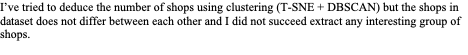

# Default and late payment on single transactions

Here I want to verify it there is any relation between late payment and default on single transaction. 
For example, is it true that client who will be late with payment on the first instalment, is more likely to not pay back the second instalment at all?


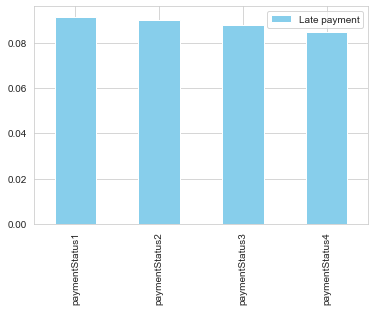

In [50]:
# late
_tmp = (df_trans.query("fraud==0").filter(regex='paymentS') == 1).astype(int)
_tmp.mean(axis=0).plot(label='Late payment', kind='bar', color='skyblue')
plt.legend() 
plt.show()

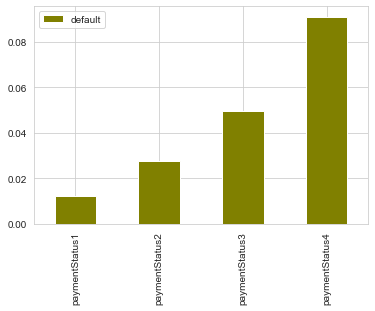

In [51]:
# default
_tmp = (df_trans.query("fraud==0").filter(regex='paymentS') == 2).astype(int)
_tmp.mean(axis=0).plot(label = 'default', kind='bar', color='olive')
plt.legend() 
plt.show()

### Transaction payment instalments

### First late, next late

If first late, then next late - no dependency (chi2 test, p-value 0.38)

In [52]:
def check_dependency(x_0, x_1, name='paymentStatus1', test=False):
    if test:
        table = [x_0,x_1]
    else:
        table = [list(x_0.sum()),list(x_1.sum())]
    stat, p, dof, expected = chi2_contingency(table)
    print(table)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Probably independent')
    else:
        print('Probably dependent')
    if test:
        return None
    return x_0.mean().to_frame(name=f'{name}_0').join(x_1.mean().to_frame(name=f'{name}_1'))

In [53]:
_tmp_f0 = df_trans.query("fraud==0").loc[df_trans.paymentStatus1==0].filter(regex='paymentStatus[2-4]').apply(lambda x: x==1).astype(int)
_tmp_f1 = df_trans.query("fraud==0").loc[df_trans.paymentStatus1==1].filter(regex='paymentStatus[2-4]').apply(lambda x: x==1).astype(int)

check_dependency(_tmp_f0, _tmp_f1).style.background_gradient(cmap ='Blues',axis=1)

[[157382, 153374, 147757], [22530, 22275, 21235]]
stat=2.167, p=0.338
Probably independent


,paymentStatus1_0,paymentStatus1_1
paymentStatus2,0.087864,0.123492
paymentStatus3,0.085627,0.122094
paymentStatus4,0.082491,0.116394


### First late, next default

If first late, then next default - no dependency (chi2 test, p-value 0.16)

In [54]:
_tmp_f0 = df_trans.query("fraud==0").loc[df_trans.paymentStatus1==0].filter(regex='paymentStatus[2-4]').apply(lambda x: x==2).astype(int)
_tmp_f1 = df_trans.query("fraud==0").loc[df_trans.paymentStatus1==1].filter(regex='paymentStatus[2-4]').apply(lambda x: x==2).astype(int)

check_dependency(_tmp_f0, _tmp_f1).style.background_gradient(cmap ='Blues',axis=1)

[[28201, 68647, 143732], [2857, 6739, 13974]]
stat=3.685, p=0.158
Probably independent


,paymentStatus1_0,paymentStatus1_1
paymentStatus2,0.015744,0.015660
paymentStatus3,0.038325,0.036938
paymentStatus4,0.080244,0.076595


### Second late, next late

In [55]:
_tmp_s0 = df_trans.query("fraud==0").loc[df_trans.paymentStatus2==0].filter(regex='paymentStatus[3-4]').apply(lambda x: x==1).astype(int)
_tmp_s1 = df_trans.query("fraud==0").loc[df_trans.paymentStatus2==1].filter(regex='paymentStatus[3-4]').apply(lambda x: x==1).astype(int)

check_dependency(_tmp_s0, _tmp_s1).style.background_gradient(cmap ='Blues',axis=1)

[[153563, 147509], [22086, 21483]]
stat=1.483, p=0.223
Probably independent


,paymentStatus1_0,paymentStatus1_1
paymentStatus3,0.087120,0.122760
paymentStatus4,0.083685,0.119408


### Second late, next default

In [56]:
_tmp_s0 = df_trans.query("fraud==0").loc[df_trans.paymentStatus2==0].filter(regex='paymentStatus[3-4]').apply(lambda x: x==2).astype(int)
_tmp_s1 = df_trans.query("fraud==0").loc[df_trans.paymentStatus2==1].filter(regex='paymentStatus[3-4]').apply(lambda x: x==2).astype(int)

check_dependency(_tmp_s0, _tmp_s1).style.background_gradient(cmap ='Blues',axis=1)

[[40431, 115478], [3897, 11170]]
stat=0.030, p=0.863
Probably independent


,paymentStatus1_0,paymentStatus1_1
paymentStatus3,0.022937,0.021661
paymentStatus4,0.065513,0.062086


# Create an Observation based on the last transaction of the clinet

In [57]:
df_trans['rank_reverse'] = df_trans.groupby("customerID")["transactionID"].rank("dense", ascending=False)

In [58]:
df_trans_newest = df_trans.loc[df_trans.rank_reverse==1].reset_index(drop=True)
df_trans_history = df_trans.loc[df_trans.rank_reverse>1].reset_index(drop=True)

Prepare some basic aggregation

In [59]:
"""
df_trans_history_aggr = df_trans_history. \
    groupby('customerID'). \
    agg(
        trans_count=('default', 'count'),
        default_sum=('default', 'sum'),
        default_mean=('default', 'mean'),
        late_sum=('late', 'sum'),
        late_mean=('late', 'mean'),
        price_sum=('price', 'sum'),
        price_mean=('price', 'mean'),
).reset_index(drop=False)
"""
df_trans_history_aggr = df_trans_history. \
    groupby('customerID'). \
    agg(
        hist_trans_count=('default', 'count'),
        hist_default_sum=('default', 'sum'),
        hist_default_avg=('default', 'mean'),
        hist_late_sum=('late', 'sum'),
        hist_late_avg=('late', 'mean'),
        hist_price_sum=('price', 'sum'),
        hist_price_avg=('price', 'mean')
    ).reset_index(drop=False)

In [60]:
df_trans_newest = df_trans_newest.merge(df_trans_history_aggr, on='customerID', how='left')

In [61]:
df_cust_trans = df_cust.merge(df_trans_newest, on = ['customerID'], how='left')

drop clients without transactions

In [62]:
df_cust_trans = df_cust_trans.dropna(subset=['default'])

# Sex vs default and late payemnts

In [63]:
_tmp = df_cust_trans.groupby('sex').agg(default_1 = ('default','sum'), default_0=('default',lambda x: np.sum(x==0)))
_tmp.T.style.format('{:.0f}')

sex,female,male,other
default_1,13774,27891,3460
default_0,84680,339496,21232


In [64]:
#Chi-Squared Test
table = [_tmp.T.values]
stat, p, dof, expected = chi2_contingency(table)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

stat=4527.014, p=0.000
Probably dependent


In [65]:
df_cust_trans.groupby('sex').agg(default_rate=('default','mean'))

,default_rate
sex,
female,0.139903
male,0.075917
other,0.140126


In [66]:
0.139903/0.075917

1.842841524296271

**Female and other are twice likely to default then man.**

In [67]:
_tmp = df_cust_trans.groupby('sex').agg(late_1 = ('late','sum'), late_0=('late',lambda x: np.sum(x==0)))
_tmp.style.format('{:.0f}')

,late_1,late_0
sex,,
female,22525,75929
male,116211,251176
other,5532,19160


In [68]:
#Chi-Squared Test
table = [_tmp.T.values]
stat, p, dof, expected = chi2_contingency(table)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

stat=3480.288, p=0.000
Probably dependent


In [69]:
df_cust_trans.groupby('sex').agg(late_rate=('late','mean'))

,late_rate
sex,
female,0.228787
male,0.316318
other,0.224040


In [70]:
0.316318/0.224040

1.4118818068202106

**male are 50% more likely to be late with payments**

# Age vs risk

In [71]:
_tmp = df_cust_trans.assign(age=pd.cut(df_cust.age, 5)).groupby('age').agg(default_1 = ('default','sum'), default_0=('default',lambda x: np.sum(x==0)))
_tmp.T.style.format('{:.0f}')

age,"(4.915, 22.0]","(22.0, 39.0]","(39.0, 56.0]","(56.0, 73.0]","(73.0, 90.0]"
default_1,5417,10574,16432,12384,318
default_0,52614,103831,162851,123037,3075


In [72]:
#Chi-Squared Test
table = [_tmp.values]
stat, p, dof, expected = chi2_contingency(table)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

stat=2.379, p=0.666
Probably independent


In [73]:
_tmp = df_cust_trans.assign(age=pd.cut(df_cust.age, 5)).groupby('age').agg(late_1 = ('late','sum'), late_0=('late',lambda x: np.sum(x==0)))
_tmp.T.style.format('{:.0f}')

age,"(4.915, 22.0]","(22.0, 39.0]","(39.0, 56.0]","(56.0, 73.0]","(73.0, 90.0]"
late_1,17106,33612,52681,39909,960
late_0,40925,80793,126602,95512,2433


In [74]:
#Chi-Squared Test
table = [_tmp.values]
stat, p, dof, expected = chi2_contingency(table)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

stat=2.509, p=0.643
Probably independent


# Income vs default and late payemnts

In [75]:
_tmp = df_cust_trans.fillna({'income':0}).\
    assign(income= lambda x: pd.cut(x.income, 5)). \
    groupby('income'). \
    agg(default_1 = ('default','sum'), default_0=('default',lambda x: np.sum(x==0)))
_tmp.T.style.format('{:.0f}')

income,"(-100.0, 20000.0]","(20000.0, 40000.0]","(40000.0, 60000.0]","(60000.0, 80000.0]","(80000.0, 100000.0]"
default_1,9826,8818,8876,8856,8749
default_0,96654,86916,87534,87040,87264


In [76]:
#Chi-Squared Test
table = [_tmp.values]
stat, p, dof, expected = chi2_contingency(table)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

stat=1.143, p=0.887
Probably independent


In [77]:
_tmp = df_cust_trans.fillna({'income':0}).\
    assign(income= lambda x: pd.cut(x.income, 5)). \
    groupby('income'). \
    agg(late_1 = ('late','sum'), default_0=('late',lambda x: np.sum(x==0)))
_tmp.T.style.format('{:.0f}')

income,"(-100.0, 20000.0]","(20000.0, 40000.0]","(40000.0, 60000.0]","(60000.0, 80000.0]","(80000.0, 100000.0]"
late_1,31213,28168,28434,28182,28271
default_0,75267,67566,67976,67714,67742


In [78]:
#Chi-Squared Test
table = [_tmp.values]
stat, p, dof, expected = chi2_contingency(table)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

stat=0.883, p=0.927
Probably independent


# Geospatial data

Use openstreetmap api to geocode residentialAddress to get information like: country, city, district/neighbourhood


In [79]:
residentialAddress_geocoded = []
for adr in df_cust.residentialAddress.sample(500, random_state=1).to_list():
    residentialAddress_geocoded += [geocoder.osm(adr.strip()).json]


In [80]:
_tmp = []
for k in residentialAddress_geocoded:
    _tmp += [pd.DataFrame.from_dict([k])]
pd_residentialAddress_geocoded = pd.concat(_tmp)

In [81]:
pd_residentialAddress_geocoded.country.value_counts() / pd_residentialAddress_geocoded.shape[0]

Australia                 0.528
United States             0.272
United Kingdom            0.090
Canada                    0.040
New Zealand / Aotearoa    0.036
Deutschland               0.010
Nederland                 0.008
Polska                    0.002
Italia                    0.002
Türkiye                   0.002
Österreich                0.002
Moldova                   0.002
Trinidad and Tobago       0.002
South Africa              0.002
Name: country, dtype: float64

In [82]:
pd_residentialAddress_geocoded.city.value_counts() / pd_residentialAddress_geocoded.shape[0]

Brisbane City    0.496
London           0.034
New York         0.020
Melbourne        0.014
Rochester        0.008
                 ...  
Long Beach       0.002
Chaguanas        0.002
Ottawa           0.002
Toronto          0.002
Birmingham       0.002
Name: city, Length: 98, dtype: float64

### Are geo data  real and is there any "risky" neighbourhood?

In [83]:
sample = df_cust_trans.sample(1000, random_state=1)

In [84]:
l_residentialAddress_geocoded = []
for adr in sample.residentialAddress.to_list():
    l_residentialAddress_geocoded += [geocoder.osm(adr.strip()+" ,Brisbane, Australia").json]


In [85]:
_tmp = []
for k in l_residentialAddress_geocoded:
    _tmp += [pd.DataFrame.from_dict([k])]
pd_residentialAddress_geocoded = pd.concat(_tmp)

In [86]:
pd_residentialAddress_geocoded['default_sum'] = sample.default.to_list()

In [87]:
pd_residentialAddress_geocoded['residentialAddress_clean'] = sample.residentialAddress_clean.to_list()

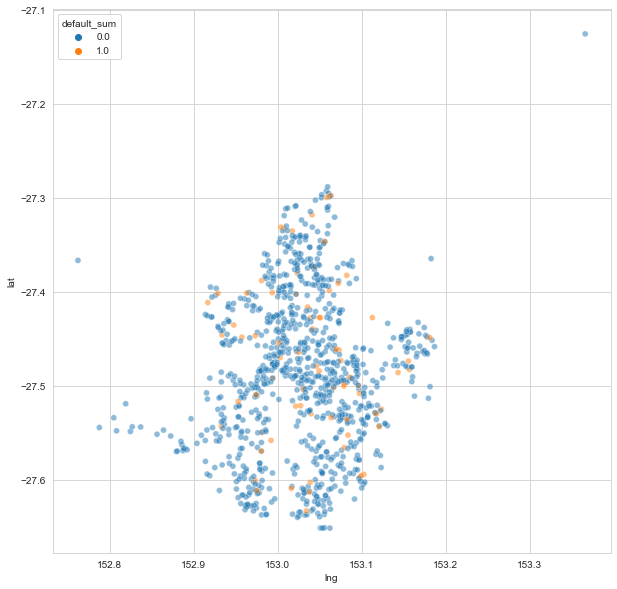

In [88]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=pd_residentialAddress_geocoded, x="lng", y="lat", hue="default_sum", alpha=0.5, ax=ax)
plt.show()

In [89]:
pd_residentialAddress_geocoded.groupby('suburb').agg(
    trans_count=('default_sum', 'count'),
    uniqe_addreses=('residentialAddress_clean', 'nunique'),
    default_sum=('default_sum', 'sum')).reset_index().\
assign(dr = lambda x: x['default_sum'] / x['trans_count']).sort_values('dr', ascending=False).head(10)


,suburb,trans_count,uniqe_addreses,default_sum,dr
127,Rocklea,1,1,1.0,1.000000
119,Pinkenba,1,1,1.0,1.000000
52,Everton Park,3,3,2.0,0.666667
88,Lutwyche,2,2,1.0,0.500000
87,Kuraby,7,7,3.0,0.428571
28,Carina Heights,5,5,2.0,0.400000
17,Bowen Hills,3,3,1.0,0.333333
166,Yeronga,3,3,1.0,0.333333
100,Morningside,9,9,3.0,0.333333
7,Ashgrove,3,3,1.0,0.333333


In [90]:
pd_residentialAddress_geocoded.groupby(['suburb','residentialAddress_clean']).agg(
    trans_count=('default_sum', 'count'),
    default=('default_sum', 'mean')).reset_index().sort_values('default').query("suburb=='Stretton'")



,suburb,residentialAddress_clean,trans_count,default
755,Stretton,White cedar Circuit,1,0.0
754,Stretton,Gardenia Close,1,0.0


### Analyse if postalAddress is the same as residentialAddress

In [91]:
df_cust_trans.groupby('same_address')['default'].mean()

same_address
0    0.313669
1    0.075445
Name: default, dtype: float64

In [92]:
0.313669/0.075445

4.1575849956922255

Default rate is significantly bigger when postalAddress is different then residentialAddress

## Create  "geo risk rating"

rate addreses based on average risk 

In [93]:
df_cust_trans.columns

Index(['customerID', 'sex', 'age', 'residentialAddress', 'postalAddress',
       'income', 'residentialAddress_clean', 'postalAddress_clean',
       'same_address', 'transactionID', 'shopID', 'price', 'paymentStatus1',
       'paymentStatus2', 'paymentStatus3', 'paymentStatus4', 'late', 'default',
       'defualted_payment', 'late_payment_first', 'money_lost', 'fraud',
       'rank_reverse', 'hist_trans_count', 'hist_default_sum',
       'hist_default_avg', 'hist_late_sum', 'hist_late_avg', 'hist_price_sum',
       'hist_price_avg'],
      dtype='object')

In [94]:
_tmp = df_cust_trans.groupby('residentialAddress_clean')[['hist_default_sum','hist_trans_count']]. \
    sum().reset_index().assign(dr = lambda x: x['hist_default_sum']/x['hist_trans_count'])

<AxesSubplot:>

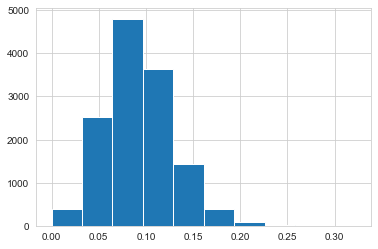

In [95]:
_tmp.dr.hist()

In [96]:
np.quantile(_tmp.dr, [i/10 for i in list(range(1,10,2))], axis=0)

array([0.04950495, 0.07216495, 0.08955224, 0.10784314, 0.13829787])

In [97]:
bins = [-np.inf, 0.049, 0.071, 0.088, 0.107, 0.137, np.inf]

In [98]:
geo_risk_rank = df_cust_trans.groupby('residentialAddress_clean')[['hist_default_sum','hist_trans_count']]. \
    sum().reset_index().assign(geo_risk_rank = lambda x: pd.cut(x['hist_default_sum']/x['hist_trans_count'], bins).cat.codes)


In [99]:
df_cust_trans = df_cust_trans.merge(geo_risk_rank[['residentialAddress_clean','geo_risk_rank']], on='residentialAddress_clean', how='left')

In [100]:
df_cust_trans

,customerID,sex,age,residentialAddress,postalAddress,income,residentialAddress_clean,postalAddress_clean,same_address,transactionID,...,fraud,rank_reverse,hist_trans_count,hist_default_sum,hist_default_avg,hist_late_sum,hist_late_avg,hist_price_sum,hist_price_avg,geo_risk_rank
0,1,male,25,28 Irvine Place,28 Irvine Place,NaN,Irvine Place,Irvine Place,1,1697842.0,...,0.0,1.0,3.0,0.0,0.000,1.0,0.333333,358.0,119.333333,4
1,2,male,19,72 Bertha Street,72 Bertha Street,43200.0,Bertha Street,Bertha Street,1,1834257.0,...,0.0,1.0,6.0,0.0,0.000,2.0,0.333333,599.0,99.833333,2
2,3,female,22,63 Ladberry Street,63 Ladberry Street,70200.0,Ladberry Street,Ladberry Street,1,1974624.0,...,0.0,1.0,8.0,1.0,0.125,1.0,0.125000,781.0,97.625000,1
3,4,other,24,98 Linneman Close,98 Linneman Close,93900.0,Linneman Close,Linneman Close,1,1536291.0,...,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,5,male,53,56 Salonica Road,56 Salonica Road,77000.0,Salonica Road,Salonica Road,1,661121.0,...,0.0,1.0,4.0,2.0,0.500,2.0,0.500000,289.0,72.250000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490528,499996,male,68,95 Argyle Parade,95 Argyle Parade,40500.0,Argyle Parade,Argyle Parade,1,665043.0,...,0.0,1.0,1.0,0.0,0.000,0.0,0.000000,173.0,173.000000,4
490529,499997,female,22,34 Bearke Place,34 Bearke Place,44900.0,Bearke Place,Bearke Place,1,1756533.0,...,0.0,1.0,2.0,0.0,0.000,0.0,0.000000,181.0,90.500000,2
490530,499998,male,27,95 Glenhurst Street,95 Glenhurst Street,48700.0,Glenhurst Street,Glenhurst Street,1,1628579.0,...,0.0,1.0,4.0,0.0,0.000,0.0,0.000000,354.0,88.500000,0
490531,499999,male,55,34 Kiandra Close,34 Kiandra Close,7600.0,Kiandra Close,Kiandra Close,1,1722718.0,...,0.0,1.0,5.0,0.0,0.000,0.0,0.000000,664.0,132.800000,1
